In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold
import time
import torch.autograd as autograd


from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)

cpu


In [4]:
#Define NN

class HarmonicModel(nn.Module):
    def __init__(self, n_in, hidden_sizes, activation):
        super().__init__()
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }

        #allow for different sizes of neurons for each layer
        layer_sizes = [n_in] + hidden_sizes + [1] #becomes for example [4, 64, 32, 16, 1]
        
        self.layers = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes)-1)
        ]) #nn.Linear(4, 64), nn.Linear(64, 32), ..., nn.Linear(16, 1)

        self.activation = act[activation] #chooses a value from the dictionary, e.g. act['tanh']

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)
    
def loss_harmonic(y_pred, y_exp):
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    return mse_y

#evaluate model
def evaluate_NN(model, data):
    model.eval()
    X_val = data["X"].to(device)
    y_val = data["y_tensor"][:, :, 0].to(device)

    with torch.no_grad():
        y_pred = model(X_val).squeeze(-1)
        loss = loss_harmonic(y_pred, y_val)

    return loss.item()

In [5]:
#Define PINN

class HarmonicModel2(nn.Module):
    def __init__(self, n_in, n_layers, n_neurons, activation):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, n_neurons))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
        layers.append(nn.Linear(n_neurons, 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

def loss_PINN2(model, y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).to(device).requires_grad_(True)

    n_rep = int(N_f / len(y_exp[0]))

    k_f = k.unsqueeze(-1).repeat(1, n_rep, 1)
    x_00_f = x_00.unsqueeze(-1).repeat(1, n_rep, 1)
    x_01_f = x_01.unsqueeze(-1).repeat(1, n_rep, 1)

    X_f = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = x_tt + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return mse_y + mse_f

#evaluate model
def evaluate_PINN(model, data, N_f=1000):
    model.eval()  # evaluation mode is fine

    X = data["X"].to(device)
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)

    y_pred = model(X).squeeze(-1)
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    # DO NOT use torch.no_grad() here
    loss = loss_PINN2(model, y_pred, y_exp, x_00, x_01, t, k, N_f)

    return loss.item()


In [6]:
#load models

# Model class must be defined somewhere
model_NN = torch.load("optimized_model_NN.pt", weights_only=False, map_location="cpu")
model_NN.eval()  # put in evaluation mode
model_PINN = torch.load("optimized_model_PINN.pt", weights_only=False, map_location=torch.device('cpu'))
model_PINN.eval()  # put in evaluation mode

HarmonicModel(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=82, bias=True)
    (1): Linear(in_features=82, out_features=119, bias=True)
    (2): Linear(in_features=119, out_features=46, bias=True)
    (3): Linear(in_features=46, out_features=124, bias=True)
    (4): Linear(in_features=124, out_features=1, bias=True)
  )
)

In [7]:
#Define dataset to compare models

torch.manual_seed(0) #get the same random numbers everytime you run the code
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

t_span = (0, 10) #wanted timespan
n_step = 100 #number of steps to train the data (number of initial conditions)
n_data = 1000 #number of data per step (per initial condition, this number of datapoints to train, validate, test data)

#validation set will be used to choose hyperparameters, decide when to stop training, compare multiple models fairly and detect overfitting
train, test = create_trainig_test_set(harmonic_osc,
                                      t_span=t_span,
                                      n_steps=n_step,
                                      n_data=n_data,
                                      coeff_test=0.3,
                                      method="RK45",
                                      device=device,
                                      seed=0)

In [8]:
#evaluate models
loss_opt_NN = evaluate_NN(model_NN, data=test)
print(f"The test loss on the optimized NN model is {loss_opt_NN}")

loss_opt_PINN = evaluate_PINN(model_PINN, data=test)
print(f"The test loss on the optimized PINN model is {loss_opt_PINN}")

The test loss on the optimized NN model is 0.006571897771209478
The test loss on the optimized PINN model is 0.49528825283050537


# Performance on noisy data

In [9]:
#Compare the performance on noisy data

def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset

In [11]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, test_no_noise = create_trainig_test_set(harmonic_osc,
                                                        t_span=(0, 10),
                                                        n_steps=100,
                                                        n_data=n_data,
                                                        coeff_test=0.3,
                                                        method="RK45",
                                                        device=device,
                                                        seed=0)

# Example: add noise with std=0.5 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]

#get prediction for NN and PINN
y_pred_noise_NN = model_NN(X).squeeze(-1)
y_pred_noise_PINN = model_PINN(X).squeeze(-1)

test_loss_noise_NN = evaluate_NN(model_NN, data=test_noise)
print(f"Test Loss noise NN: {test_loss_noise_NN:.4f}")
test_loss_noise_PINN = evaluate_PINN(model_PINN, data=test_noise)
print(f"Test Loss noise PINN: {test_loss_noise_PINN:.4f}")

Test Loss noise NN: 0.2552
Test Loss noise PINN: 0.7440


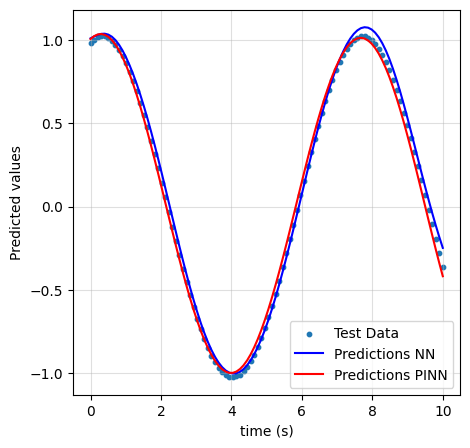

In [12]:
#plot of models
#Look at performance on test data
X = test["X"]

y_pred_opt_NN = model_NN(X).squeeze(-1)
y_pred_opt_PINN = model_PINN(X).squeeze(-1)

n = 100 #defines which initial conditions we look at?

plt.figure(figsize=(5, 5))
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], s=10, label="Test Data")
plt.plot(test["t_tensor"][n], y_pred_opt_NN.cpu().detach()[n], color="blue", label="Predictions NN")
plt.plot(test["t_tensor"][n], y_pred_opt_PINN.cpu().detach()[n], color="red", label="Predictions PINN")
plt.xlabel("time (s)")
plt.ylabel("Predicted values")
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("Images/Prediction_NN_PINN")
plt.show()

/tmp/ipykernel_970/3511694621.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_analytical = x0 * np.cos(w * test_noise["t_tensor"][n]) + (v0 / w) * np.sin(w * test_noise["t_tensor"][n])
/tmp/ipykernel_970/3511694621.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (x_analytical/sol.y[0])[::slice]


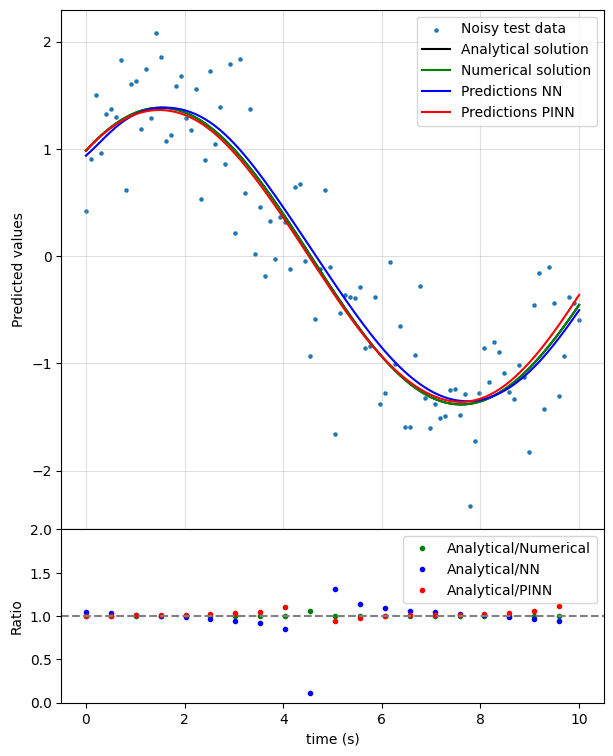

In [13]:
#Plot the results
n = 0

y_pred_noise_NN.to("cpu")
y_pred_noise_PINN.to("cpu")
test_noise["t_tensor"].to("cpu")
k = test_noise["args_tensor"][n]

# Analytical solution
x0 = float(test_noise["x0_tensor"][n][0])
v0 = float(test_noise["x0_tensor"][n][1])

# Extract k
k_val = float(k)  # assuming w = k

# Compute angular frequency
w = np.sqrt(k_val)
x_analytical = x0 * np.cos(w * test_noise["t_tensor"][n]) + (v0 / w) * np.sin(w * test_noise["t_tensor"][n])


#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(k))

# Create figure with GridSpec
fig = plt.figure(figsize=(7, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)

#create ratios for lower plot
slice = 5 #so that the plot is clear
ratio_an_num = (x_analytical/sol.y[0])[::slice]
ratio_an_NN = (x_analytical/y_pred_noise_NN.cpu().detach()[n])[::slice]
ratio_an_PINN = (x_analytical/y_pred_noise_PINN.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], s=5, label="Noisy test data") #Training data
ax_main.plot(sol.t, x_analytical, label='Analytical solution', color = 'black') #Analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'green') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise_NN.cpu().detach()[n], color="blue", label="Predictions NN") #NN ML
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise_PINN.cpu().detach()[n], color="red", label="Predictions PINN") #PINN ML
ax_main.set_ylabel('Predicted values')
ax_main.legend()
ax_main.grid(alpha=0.4)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='green')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='blue')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_PINN, '.', label='Analytical/PINN', color='red')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('time (s)')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(0, 2)
ax_ratio.legend()
plt.savefig("Images/noise_NN_PINN")
plt.show()

# Generalization

In [14]:
#Generalization
train_generalization, test_generalization = create_trainig_test_set(harmonic_osc,
                                                                    t_span=(0, 30),
                                                                    n_steps=200,
                                                                    n_data=n_data,
                                                                    coeff_test=0.3,
                                                                    method="RK45",
                                                                    device=device,
                                                                    seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_generalization_NN = model_NN(X).squeeze(-1)
y_pred_generalization_PINN = model_PINN(X).squeeze(-1)


test_loss_generalization_NN = evaluate_NN(model_NN, data=test_generalization)
print(f"Test Loss generalization NN: {test_loss_generalization_NN:.4f}")
test_loss_generalization_PINN = evaluate_PINN(model_PINN, data=test_generalization)
print(f"Test Loss generalization PINN: {test_loss_generalization_PINN:.4f}")

Test Loss generalization NN: 1.9481
Test Loss generalization PINN: 1.8547


In [27]:
#Implementation G_l metric
epsilon = [1e-5, 1e-4, 1e-3, 1e-2]

def compute_Gl(model, X_test, y_test, train_domain, epsilon):
    """
    Compute G_l^epsilon for a 1D PINN or neural network model.
    X_test: tensor of test inputs
    y_test: tensor of true outputs
    train_domain: (train_min, train_max)
    epsilon: allowed absolute error
    """
    T_test = X_test[:,:,3]
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).squeeze(-1)

    # absolute prediction error
    err = torch.abs(y_pred - y_test[:, :, 0]).cpu()#.numpy()
    X = X_test.cpu().numpy().flatten()

    # training region
    t_min, t_max = train_domain #(0,10)


    # mask for outside the training region
    outside_mask = (T_test.numpy() < t_min) | (T_test.numpy() > t_max) #True if time outside training domain

    # mask for good prediction (error < epsilon)
    good_mask = err.numpy() < epsilon #true if model prediction error smaller than epsilon

    # allowed region = outside & good
    valid_mask = outside_mask & good_mask #both outside training domain and accurate, size 300*200
    valid_mask_flat = valid_mask.flatten()

    # indices where valid
    idx = np.where(valid_mask_flat) #row indices of valid points (outside and accurate)
    if len(idx[0]) == 0: #if no points outside and accurate
        return 0.0  # no generalization outside training domain

    # find maximal contiguous interval
    intervals = []
    start = idx[0][0]
    for i in range(1, len(idx[0])):
        if idx[0][i] != idx[0][i-1] + 1:
            intervals.append((start, idx[0][i-1]))
            start = idx[0][i]
    intervals.append((start, idx[0][-1]))

    # compute lengths
    max_len = 0
    for (i0, i1) in intervals:
        interval_len = T_test.numpy().flatten()[i1]-T_test.numpy().flatten()[i0]
        if interval_len > max_len:
            max_len = interval_len

    # training domain length
    train_len = t_max - t_min
    return max_len / train_len

# --- Extract training domain ---
t_train = test_generalization["t_tensor"].to("cpu")
t_train_min = 0
t_train_max = 10
train_domain = (t_train_min, t_train_max)

# --- Extract test data ---
X_test = test_generalization["X"]
y_test = test_generalization["y_tensor"]

# --- Choose tolerance epsilon ---
epsilon = 0.001  # you may tune this

# --- Compute GL for both models ---
Gl_NN = compute_Gl(model_NN, X_test, y_test, train_domain, 0.001)
Gl_PINN = compute_Gl(model_PINN, X_test, y_test, train_domain, epsilon)

print(f"G_l^ε for NN: {Gl_NN:.3f}")
print(f"G_l^ε for PINN: {Gl_PINN:.3f}")

G_l^ε for NN: 0.045
G_l^ε for PINN: 0.075


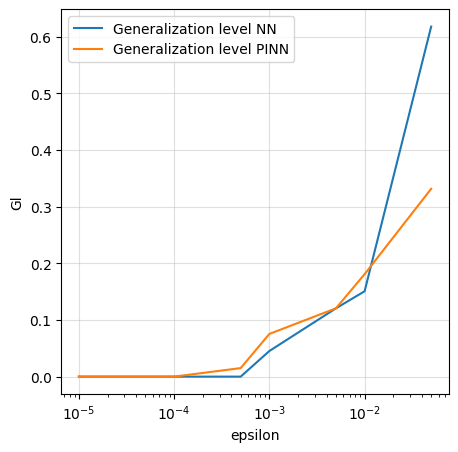

In [41]:
#Plot results for different epsilons
epsilon_values = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
GL_NN = []
GL_PINN=[]

for epsilon in epsilon_values:
    # --- Compute GL for both models ---
    Gl_NN = compute_Gl(model_NN, X_test, y_test, train_domain, epsilon)
    Gl_PINN = compute_Gl(model_PINN, X_test, y_test, train_domain, epsilon)

    #add to list
    GL_NN.append(Gl_NN)
    GL_PINN.append(Gl_PINN)

#plot results
plt.figure(figsize=(5, 5))
plt.plot(epsilon_values, GL_NN, label="Generalization level NN")
plt.plot(epsilon_values, GL_PINN, label="Generalization level PINN")
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel("epsilon")
plt.ylabel("Gl")
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("Images/GL_Epsilon_NN_PINN.png")
plt.show()

/tmp/ipykernel_970/2870656367.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_analytical = x0 * np.cos(w * test_generalization["t_tensor"][n]) + (v0 / w) * np.sin(w * test_generalization["t_tensor"][n])
/tmp/ipykernel_970/2870656367.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (x_analytical/sol.y[0])[::slice]


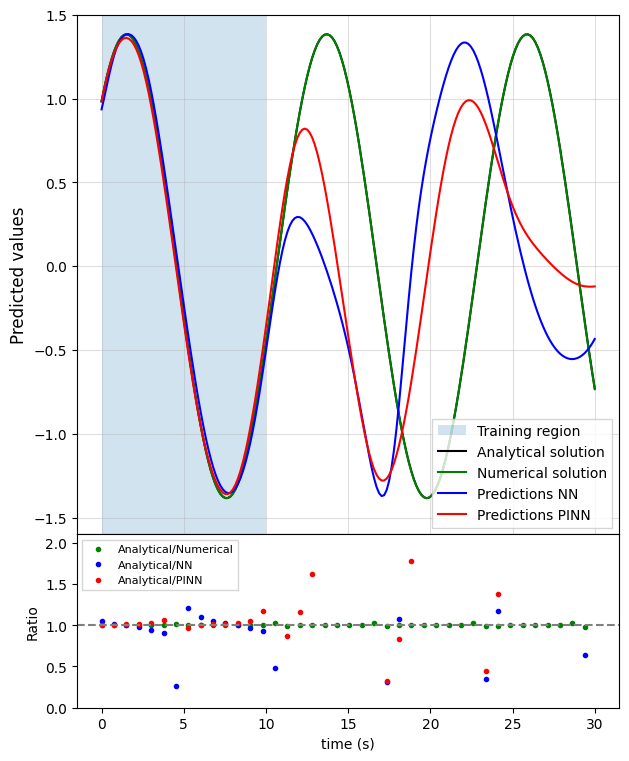

In [15]:
n = 0

y_pred_generalization_NN.to("cpu")
y_pred_generalization_PINN.to("cpu")
test_generalization["t_tensor"].to("cpu")
k = test_generalization["args_tensor"][n]

# Analytical solution
x0 = float(test_generalization["x0_tensor"][n][0])
v0 = float(test_generalization["x0_tensor"][n][1])

# Extract k
k_val = float(k)  # assuming w = k

# Compute angular frequency
w = np.sqrt(k_val)
x_analytical = x0 * np.cos(w * test_generalization["t_tensor"][n]) + (v0 / w) * np.sin(w * test_generalization["t_tensor"][n])

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
k = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(k))

# Create figure with GridSpec
fig = plt.figure(figsize=(7, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)

#create ratios for lower plot
slice = 5
ratio_an_num = (x_analytical/sol.y[0])[::slice]
ratio_an_NN = (x_analytical/y_pred_generalization_NN.cpu().detach()[n])[::slice]
ratio_an_PINN = (x_analytical/y_pred_generalization_PINN.cpu().detach()[n])[::slice]

#plot only training points until 10s
t_train = test_generalization["t_tensor"][n]
y_train = test_generalization["y_tensor"][n][:, 0]
mask = t_train <= 10.0   # keep only t ≤ 10 s

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.axvspan(0, 10, alpha=0.2, label='Training region')
ax_main.plot(test_generalization["t_tensor"][n], x_analytical, label='Analytical solution', color = 'black') #Analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'green') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization_NN.cpu().detach()[n], color="blue", label="Predictions NN") #NN ML
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization_PINN.cpu().detach()[n], color="red", label="Predictions PINN") #PINN ML
ax_main.set_ylabel('Predicted values', fontsize=12)
ax_main.legend(fontsize=10, fancybox=False)
ax_main.grid(alpha=0.4)
ax_main.set_ylim(-1.6, 1.5)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='green')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='blue')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_PINN, '.', label='Analytical/PINN', color='red')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('time (s)')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(0, 2.1)
ax_ratio.legend(fontsize=8, fancybox=False)
plt.savefig("Images/generalisation_NN_PINN")
plt.show()

# Energy conservation

Add energy conservation of numerical method?

/tmp/ipykernel_970/3236971433.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_analytical = x0 * np.cos(w * test_generalization["t_tensor"][n]) + (v0 / w) * np.sin(w * test_generalization["t_tensor"][n])
/tmp/ipykernel_970/3236971433.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  v_analytical = -x0 * w * np.sin(w * test_generalization["t_tensor"][n]) +  v0 * np.cos(w * test_generalization["t_tensor"][n])


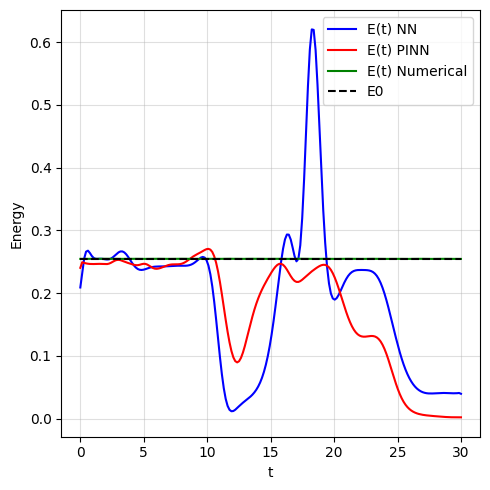

In [16]:
n = 0  # choose trajectory index

#Energy analytical (true)
x_analytical = x0 * np.cos(w * test_generalization["t_tensor"][n]) + (v0 / w) * np.sin(w * test_generalization["t_tensor"][n])
v_analytical = -x0 * w * np.sin(w * test_generalization["t_tensor"][n]) +  v0 * np.cos(w * test_generalization["t_tensor"][n])
E_analytical = 0.5 * v_analytical**2 + 0.5 * float(w)**2 * x_analytical**2

#Energy conservation numerical system
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
k = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(k))
x = sol.y[0]     # position
v = sol.y[1]     # velocity

w_value = np.sqrt(float(k))
E_num = 0.5 * v**2 + 0.5 * w_value**2 * x**2
E0_num = E_num[0]

# Position
x_NN = y_pred_generalization_NN[n].detach().cpu().numpy()
x_PINN = y_pred_generalization_PINN[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v_NN = np.gradient(x_NN, t)
v_PINN = np.gradient(x_PINN, t)

w = np.sqrt(k_val)
#Energy conservation (check on generalized data)
E_t_NN = 0.5 * v_NN**2 + 0.5 * w**2 * x_NN**2
E_t_PINN = 0.5 * v_PINN**2 + 0.5 * w**2 * x_PINN**2

plt.figure(figsize=(5, 5))
plt.plot(test_generalization["t_tensor"][n], E_t_NN, label='E(t) NN', color="blue")
plt.plot(test_generalization["t_tensor"][n], E_t_PINN, label='E(t) PINN', color="red")
plt.plot(test_generalization["t_tensor"][n], E_num, label='E(t) Numerical', color="green")
plt.hlines(E_analytical[0], sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
plt.xlabel('t')
plt.ylabel('Energy')
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig("Images/Energy_NN_PINN")
plt.show()

# Computational time

In [17]:
n=0

#Computation time
N = 200 #number of times we compute the time
timesteps_NN = np.zeros(N)
timesteps_PINN = np.zeros(N)
timesteps_Num = np.zeros(N)
N_list = np.arange(0,N)

X = test["X"][n]
y0 = [test["x0_tensor"][n][0], test["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test["t_tensor"][n][0], test["t_tensor"][n][-1]
w = test["args_tensor"][n]

#NN
for i, el in tqdm(enumerate(N_list), desc="Computation time NN: "):
    begin = time.perf_counter()
    for _ in range(el):
        model_NN(X)
    end = time.perf_counter()
    timesteps_NN[i] = end-begin

#PINN
for i, el in tqdm(enumerate(N_list), desc="Computation time PINN: "):
    begin = time.perf_counter()
    for _ in range(el):
        model_PINN(X)
    end = time.perf_counter()
    timesteps_PINN[i] = end-begin

#Numerical
for i, el in tqdm(enumerate(N_list), desc="Computation time Numerical: "):
    begin = time.perf_counter()
    for _ in range(el):
        sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test["t_tensor"][n], method='RK45', args=(w))
    end = time.perf_counter()
    timesteps_Num[i] = end-begin

Computation time NN: : 0it [00:00, ?it/s]

Computation time NN: : 200it [00:05, 35.03it/s]
Computation time PINN: : 200it [00:06, 33.03it/s]
Computation time Numerical: : 200it [00:46,  4.33it/s]


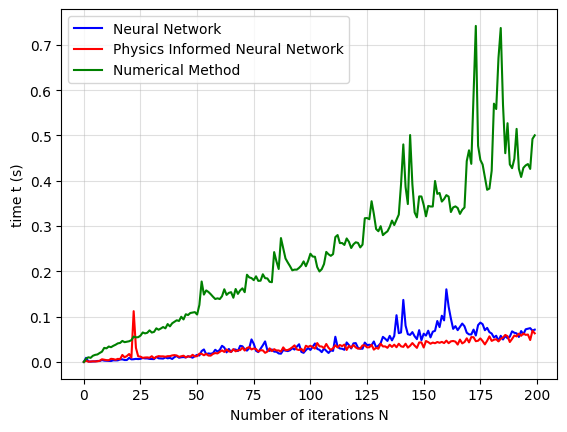

In [18]:
#Plot results computational time
plt.plot(N_list, timesteps_NN, color='blue', label="Neural Network")
plt.plot(N_list, timesteps_PINN, color='red', label="Physics Informed Neural Network")
plt.plot(N_list, timesteps_Num, color='green', label="Numerical Method")
plt.xlabel("Number of iterations N")
plt.ylabel("time t (s)")
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("Images/Time_NN_PINN")
plt.show()

# Test performance in function of number of Training data

Do this individually for NN and PINN. If needed we can just export the data separately and plot it then instead of saving the model